In [1]:
import utils as local_utils
import torch
import torch.nn as nn
#import pytorch_utils
import torch.optim as optim
import torch.optim as optim
import torch.utils.data as DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import sys
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from importlib import reload
import torch.nn.functional as F
from torchvision import transforms, utils, models
import os, sys
from random import shuffle
import torchvision.transforms as T

%matplotlib inline

In [2]:
USE_GPU = True
IMG_SZ = 224

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


## Load dataset

In [3]:
# Custom dataset
class LandmarksDataset(DataLoader.Dataset):

    def __init__(self, src_folder, transform=None):
        """
        Args:
            src_folder (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.filenames = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f)) 
                          and f != '.DS_Store']
        self.src_folder = src_folder
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.src_folder, self.filenames[idx])
        
        x = Image.open(img_name)

        if self.transform:
            x = self.transform(x)

        imgf = self.filenames[idx]
        y = int(imgf[imgf.index('_') + 1 : imgf.index('.')]) # filename format: [id_label.jpg]
        sample = (x, y)
        return sample
    
# get loaders
def get_loader(directory, batch_size, img_sz=None):
    '''
    takes in directory for train and val data, and returns loaders for both
    applies normalization:
      1. convert values to range 0-1
      2. set mean, std to those specified in pytorch pretrained models (https://pytorch.org/docs/master/torchvision/models.html)

    usage:
        loader_train = get_loader(train_directory, batch_sz)
        loader_val = get_loader(val_directory, batch_sz)
    '''
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

    if img_sz == None:
        preprocess = transforms.Compose([
            transforms.ToTensor(),  # converts to range 0-1
            #normalize               # sets mean, std
        ])
    else:
        preprocess = transforms.Compose([
            transforms.Resize((IMG_SZ, IMG_SZ)), # resize img (ie, for Inception)
            transforms.ToTensor(),  # converts to range 0-1
            #normalize               # sets mean, std
        ])

    dset = LandmarksDataset(directory, transform=preprocess)
    loader = DataLoader.DataLoader(dataset=dset, batch_size=batch_size)

    print ('dataset size', len(dset))
    return loader   

In [51]:
def get_data_numpy(src_folder):
    '''
    returns X, Y as numpy arrays
    X: (N, 224, 224, 3)
    Y: (N,)
    '''
    filenames = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f)) 
                          and f != '.DS_Store']
    
    shuffle(filenames)
    
    filenames = filenames[:20]
    
    X, Y = [], []
    
    for f in filenames:
        img_name = os.path.join(src_folder, f)
        img = Image.open(img_name)
        img.load()
        x = np.asarray(img, dtype='uint8')
        y = int(f[f.index('_') + 1 : f.index('.')]) # filename format: [id_label.jpg]
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)  

In [52]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

## Compute Saliency Maps

In [53]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[-0.8384,  0.7651,  0.0059,  0.4667,  0.4970],
        [-1.2490,  0.0593,  0.0425,  1.4381,  0.1030],
        [ 2.3895, -0.1161, -1.5377, -0.4774,  0.4258],
        [ 0.6683,  2.2899, -0.0952,  0.7538,  2.2003]])
tensor([ 1,  2,  1,  3])
tensor([ 0.7651,  0.0425, -0.1161,  0.7538])


In [54]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    
    scores = model(X)
    loss = torch.sum(scores.gather(1, y.view(-1, 1)).squeeze())
    
    loss.backward()
    
    with torch.no_grad():
        grad_abs = torch.abs(X.grad)
        N, _, H, W = X.shape
        saliency = torch.empty(N, H, W)
    
        for i, d_img in enumerate(grad_abs):
            t, _ = torch.max(d_img, 0)
            saliency[i] = t
        
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [55]:
def show_saliency_maps(X, y, model):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(y[i])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

In [84]:
def show_saliency_maps_v2(X, y, model):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    
    nRow_units = 2
    nCols = 6

    f, axarr = plt.subplots(nRow_units * 2, nCols, figsize=(15,10))
    #axarr[0].axis('off')
    #axarr[1].axis('off')
    #axarr[0].set_title('Content Source Img.')
    #axarr[1].set_title('Style Source Img.')

    # plot original images
    n = 0
    for i in range(nRow_units):
        for j in range(nCols):
            axarr[2 * i, j].imshow(X[n])
            axarr[2 * i, j].axis('off')
            n += 1
       
    # plot corresponding saliency maps
    n = 0
    for i in range(nRow_units):
        for j in range(nCols):
            axarr[2 * i + 1, j].imshow(saliency[n], cmap=plt.cm.hot)
            axarr[2 * i + 1, j].axis('off')
            n += 1

    plt.show()
    plt.figure()

## Run 

(20, 224, 224, 3) (20,)


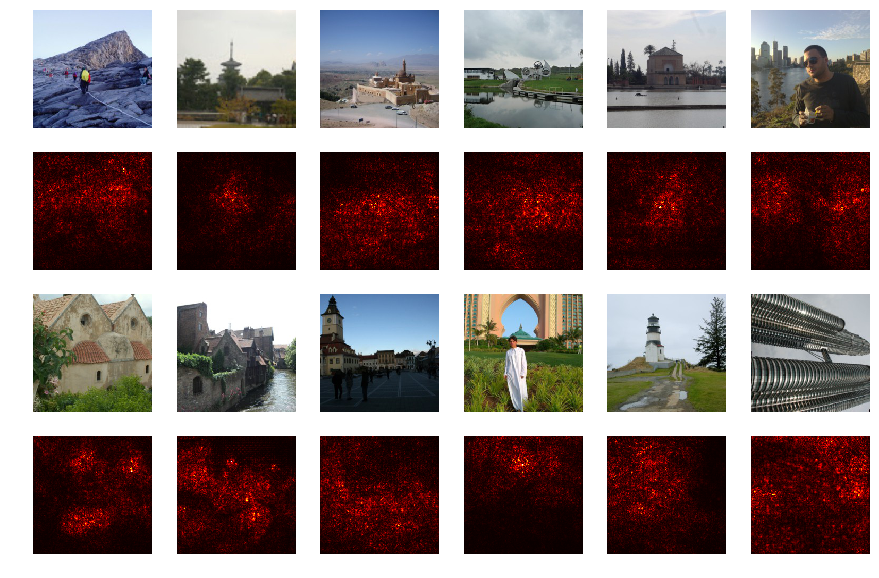

In [89]:
# load data
train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/train'
batch_size = 4
num_classes = 200

# load as np dnarray
X, Y = get_data_numpy(train_directory)


print (X.shape, Y.shape)

# Download and load the pretrained SqueezeNet model.
#model = models.squeezenet1_1(pretrained=True)

# load saved model from final best model (resnet18, 2 epochs)
model = torch.load('best_resnet_model.pt')

        
# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

show_saliency_maps_v2(X, Y, model)

In [24]:
mod2 = torch.load('my_saved_model.pt')

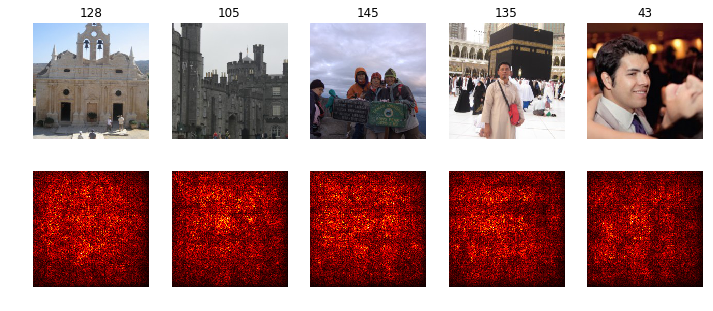

In [25]:

for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

show_saliency_maps(X, Y, model)

In [18]:
mod3 = torch.load('my_saved_model.pt')

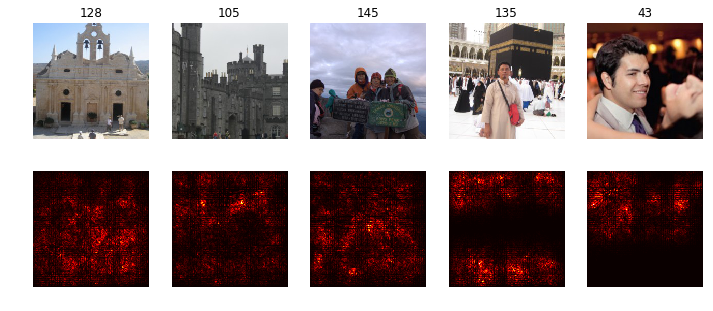

In [19]:
for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

show_saliency_maps(X, Y, model)